In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import random
import torch
import pickle
from decimal import Decimal
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import KFold
from modules.function import get_elem_count, alt_read_gfa_dataset, PTR, check_cuda, get_metrics, image, pymatgen_comp, special_formatting, data_generator_gfa
from modules.encoder import Encoder1D, EncoderDNN, Encoder
import re
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import joblib
from modules.representation_schemes import enc1d_features, get_PTR_features, get_vectorized_featues, properties_from_comp
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [4]:
phases_file = 'Files_from_GTDL_paper/gao_data.txt'
[x0,dataY]=pickle.load(open(phases_file, 'rb'))
comps = [y.split(' ')[1] for y in x0]
pmg_comps = pymatgen_comp(comps)
y = np.array(dataY)

In [5]:
with open('misc/pca_components.pkl','rb') as fid:
    component_dict = pickle.load(fid)

In [27]:
selected_els = ['Al','Ni','Fe','Cr','Ti','Nb','Ta','La','Mg','Mo']
filename = 'misc/hea_phase_gen_splits.json'
if os.path.exists(filename):
    with open(filename,'rb') as fid:
        hea_phase_gen_dict = json.load(fid)
        print('Split file loaded')
else:
    hea_phase_gen_dict = {}
    for el in selected_els:
        train_inds, test_inds,all_cv_train, all_cv_test = [],[],[],[]
        for i,c in enumerate(pmg_comps):
            if el in c.get_el_amt_dict().keys():
                test_inds.append(i)
            else:
                train_inds.append(i)
        X_train = np.array(pmg_comps)[train_inds]
        kf = KFold(n_splits=10)
        for tr, ts in kf.split(X_train):
            all_cv_train.append(tr.tolist())
            all_cv_test.append(ts.tolist())
        hea_phase_gen_dict[el] = {'train':train_inds,'test':test_inds, 'cv_train':all_cv_train, 'cv_test':all_cv_test}
    with open(filename,'w') as fid:
        json.dump(hea_phase_gen_dict, fid)
        print('Split file written!')

Split file written!


In [30]:
np.random.seed(0)
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
mean_score_list = []
std_score_list = []
results_dict = {}
for i, method in enumerate(methods):
    results_dict[method] = {}
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(pmg_comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(pmg_comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(pmg_comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(pmg_comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(pmg_comps)
    elif method ==' dense':
        extracted = enc1d_features(pmg_comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    X = pca.fit_transform(extracted)
    y = np.array(dataY)
    for k in hea_phase_gen_dict.keys():
        
        f1_max = 0
        best_fold_model = 0
        LOEO_dict = {'Fold_stats':{}}
        test_inds = hea_phase_gen_dict[k]['test']
        X_test = X[test_inds]
        y_test = y[test_inds]
        cv_train_inds, cv_test_inds = hea_phase_gen_dict[k]['cv_train'],hea_phase_gen_dict[k]['cv_test']
        score_fold, score_test = [], []
        fold_score = {}
        for i in range(len(cv_train_inds)):
            fold_train_inds, fold_test_inds = cv_train_inds[i], cv_test_inds[i]
            X_train_fold,y_train_fold  = X[fold_train_inds], y[fold_train_inds]
            X_test_fold, y_test_fold = X[fold_test_inds], y[fold_test_inds]
            randomforest = RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=500)
            randomforest.fit(X_train_fold, y_train_fold)
            yte_pred_fold = randomforest.predict(X_test_fold)
            yte_pred_test = randomforest.predict(X_test)
            report_fold = metrics.classification_report(y_test_fold, yte_pred_fold,output_dict=True)
            report_test = metrics.classification_report(y_test, yte_pred_test,output_dict=True)
            fold_micro_avg_fold = report_fold['weighted avg'].values()
            fold_micro_avg_test = report_test['weighted avg'].values()
            score_fold.append(fold_micro_avg_fold)
            score_test.append(fold_micro_avg_test)
        fold_score = {'train':score_fold,'test':score_test}
        LOEO_dict['Fold_stats'] = fold_score
        results_dict[method][k] = LOEO_dict

atomic
random
pettifor
mod_pettifor
PTR
dense


In [113]:
simplified_dict_mean, simplified_dict_std = {},{}
for el in selected_els:
    simplified_dict_mean[el], simplified_dict_std[el] = {},{}

    for method in methods:
        score = results_dict[method][el]['Fold_stats']['test']
        score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
        simplified_dict_mean[el][method] = score.mean().values[-2]
        simplified_dict_std[el][method] = score.std().values[-2]


In [117]:
mean_df = pd.DataFrame.from_dict(simplified_dict_mean, orient='index')
std_df = pd.DataFrame.from_dict(simplified_dict_std, orient='index')
mean_df

,atomic,random,pettifor,mod_pettifor,PTR,dense
Al,0.797133,0.777665,0.774447,0.775159,0.769020,0.800499
Ni,0.746731,0.719785,0.719207,0.700750,0.709995,0.777733
Fe,0.874798,0.860065,0.867835,0.828225,0.862514,0.889454
Cr,0.929163,0.926892,0.917018,0.903146,0.926761,0.930674
Ti,0.720717,0.725073,0.722962,0.711031,0.710433,0.716407
Nb,0.847978,0.817228,0.850724,0.830801,0.866372,0.887887
Ta,0.968604,0.961981,0.949246,0.944645,0.958495,0.963041
La,0.968883,0.937458,0.968548,0.948495,0.980589,0.930546
Mg,0.936185,0.944145,0.951273,0.989744,0.972185,0.898310
Mo,0.861063,0.857610,0.865948,0.847482,0.854701,0.852583


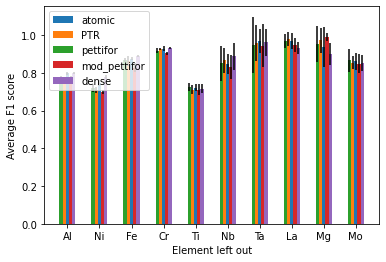

In [119]:
import matplotlib.pyplot as plt
plt.bar(np.arange(mean_df.shape[0]), mean_df['atomic'].values, 0.1,label = 'atomic', yerr = std_df['atomic'].values)
plt.bar(np.arange(mean_df.shape[0]) - 0.1, mean_df['PTR'].values,0.1, label = 'PTR',yerr = std_df['PTR'].values)
plt.bar(np.arange(mean_df.shape[0]) - 0.2, mean_df['pettifor'].values,0.1, label = 'pettifor',yerr = std_df['pettifor'].values)
plt.bar(np.arange(mean_df.shape[0]) + 0.1, mean_df['mod_pettifor'].values,0.1, label = 'mod_pettifor',yerr = std_df['mod_pettifor'].values)
plt.bar(np.arange(mean_df.shape[0]) + 0.2, mean_df['dense'].values,0.1, label = 'dense',yerr = std_df['dense'].values)
plt.xticks(np.arange(mean_df.shape[0]), labels=mean_df.index)
plt.ylabel('Average F1 score')
plt.xlabel('Element left out')
plt.legend()

In [116]:
std_df['atomic']

Al    0.797133
Ni    0.746731
Fe    0.874798
Cr    0.929163
Ti    0.720717
Nb    0.847978
Ta    0.968604
La    0.968883
Mg    0.936185
Mo    0.861063
Name: atomic, dtype: float64